
# Random Orthogonal Measurements, Cosine Basis, ADMM

This example has following features:

* The signal being measured is not sparse by itself.
* It does have a sparse representation in discrete cosine basis.
* Measurements are taken by a partial Walsh Hadamard sensing matrix
  with small number of orthonormal rows
* The number of measurements is 8 times lower than the dimension of
  the signal space.
* ADMM based Basis pursuit denoising is being used to solve the recovery problem.

This example is adapted from YALL1 package.


Let's import necessary libraries 



In [1]:
import jax.numpy as jnp
from jax import random
norm = jnp.linalg.norm

import matplotlib as mpl
import matplotlib.pyplot as plt

from cr.sparse import lop
from cr.sparse.cvx.adm import yall1

## Setup



In [2]:
# Number of measurements
m = 1024
# Ambient dimension
n = m*8

key = random.PRNGKey(0)
keys = random.split(key, 4)

## Non-sparse signal



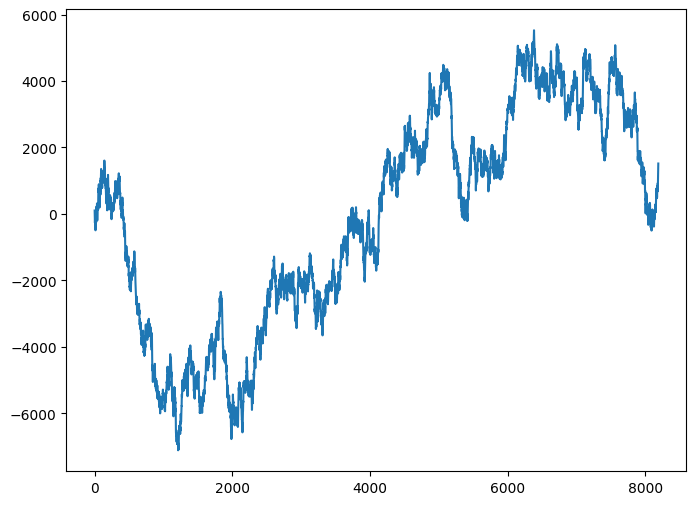

In [3]:
xs = 100 * jnp.cumsum(random.normal(keys[0], (n,)))
plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(xs)

## The Sparsifying Basis



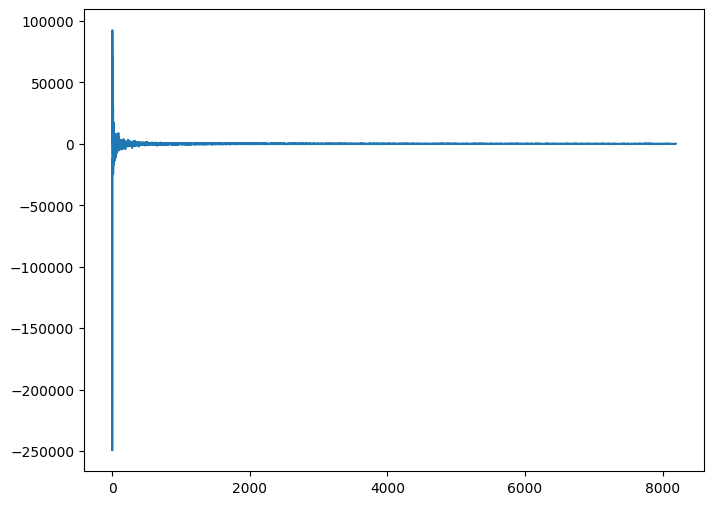

In [4]:
Psi  = lop.jit(lop.cosine_basis(n))

alpha = Psi.trans(xs)
plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(alpha)

## Partial Walsh Hadamard Measurements Operator



In [5]:
# indices of the measurements to be picked
p = random.permutation(keys[1], n)
picks = jnp.sort(p[:m])
# Make sure that DC component is always picked up
picks = picks.at[0].set(0)
print(f"{picks=}")

# a random permutation of input
perm = random.permutation(keys[2], n)
print(f"{perm=}")

# Walsh Hadamard Basis operator
Twh = lop.walsh_hadamard_basis(n)

# Wrap it with picks and perm
Tpwh = lop.jit(lop.partial_op(Twh, picks, perm))

picks=Array([   0,    5,    6, ..., 8164, 8174, 8176], dtype=int32)
perm=Array([3922, 5181, 4281, ...,  865, 4172, 1467], dtype=int32)


## Measurement process



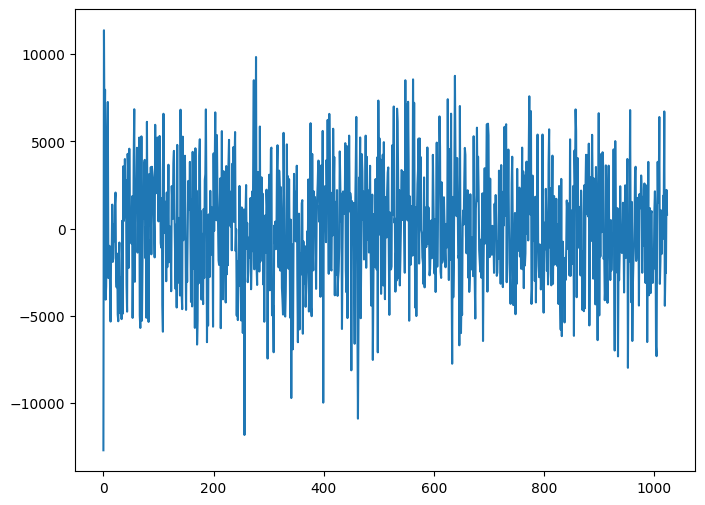

In [6]:
# Perform exact measurement
bs = Tpwh.times(xs)

# Add some noise
sigma = 0.2
noise = sigma * random.normal(keys[3], (m,))
b = bs + noise

plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(b)

## Recovery using ADMM



In [7]:
# tolerance for solution convergence
tol = 5e-4
# BPDN parameter
rho = 5e-4
# Run the solver
sol = yall1.solve(Tpwh, b, rho=rho, tolerance=tol, W=Psi)
iterations = int(sol.iterations)
#Number of iterations
print(f'{iterations=}')
# Relative error
rel_error = norm(sol.x-xs)/norm(xs)
print(f'{rel_error=:.4e}')

iterations=224
rel_error=1.0266e-01


## Solution 



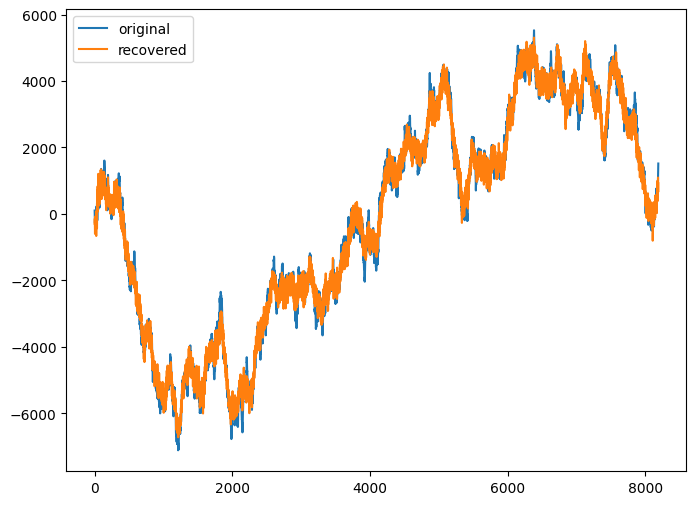

In [8]:
plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(xs, label='original')
plt.plot(sol.x, label='recovered')
plt.legend()